In [1]:
import copy
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

In [2]:
ga = 2       # CRRA utility with parameter gamma
alpha = 0.35 # Production function F = K^alpha * L^(1-alpha) 
delta = 0.1  # Capital depreciation
zmean = 1.0  # mean O-U process (in levels). This parameter has to be adjusted to ensure that the mean of z (truncated gaussian) is 1.
sig2 = (0.1)**2  # sigma^2 O-U
Corr = np.exp(-0.3)  # persistence -log(Corr)  O-U
rho = 0.05   # discount rate

K = 3.8       # initial aggregate capital. It is important to guess a value close to the solution for the algorithm to converge
relax = 0.99  # relaxation parameter 
J = 40        # number of z points 
zmin = 0.5    # Range z
zmax = 1.5
amin = -1     # borrowing constraint
amax = 30     # range a
I = 100       # number of a points 

#simulation parameters
maxit  = 100     # maximum number of iterations in the HJB loop
maxitK = 100     # maximum number of iterations in the K loop
crit = 10**(-10)  # criterion HJB loop
critK = 10**(-7) # criterion K loop
Delta = 1000     # delta in HJB algorithm

#ORNSTEIN-UHLENBECK IN LEVELS
the = -np.log(Corr)
Var = sig2/(2*the)


a = np.linspace(amin,amax,I).reshape((I,1))
da = (amax-amin)/(I-1)

z = np.linspace(zmin,zmax,J).reshape((J,1))
dz = (zmax-zmin)/(J-1)
dz2 = dz**2

aa = a * np.ones((I, J))
zz = np.ones((I, J)) * z.T

mu = the*(zmean - z).reshape((1,J))
s2 = sig2*np.ones((1,J))

Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

#chi =  (-np.minimum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))
#yy =  (np.minimum(mu,0)/dz - np.maximum(mu,0)/dz - s2/dz2).reshape((J,1))
#zeta = (np.maximum(mu,0)/dz + s2/(2*dz2)).reshape((J,1))

chi = (s2/(2*dz2)).reshape((J,1))
yy = (- s2/dz2 - mu/dz).reshape((J,1))
zeta = (mu/dz + s2/(2*dz2)).reshape((J,1))

原先是:
$$
\chi_{j} = -\frac{\mu^-_j}{\Delta z}+\frac{\sigma_j^2}{2(\Delta z)^2}\\
v_j = \frac{\mu^-_j}{\Delta z} - \frac{\mu^+_j}{\Delta z} - \frac{\sigma_j^2}{2(\Delta z)^2}\\
\zeta_j = \frac{\mu^+_j}{\Delta z} + \frac{\sigma_j^2}{2(\Delta z)^2}
$$
现在变成:
$$
\chi_{j} = \frac{\sigma_j^2}{2(\Delta z)^2}\\
v_j = - \frac{\mu_j}{\Delta z} - \frac{\sigma_j^2}{2(\Delta z)^2}\\
\zeta_j = \frac{\mu_j}{\Delta z} + \frac{\sigma_j^2}{2(\Delta z)^2}
$$

In [3]:
# This will be the upperdiagonal of the B_switch  page 18 C
updiag = np.zeros((I,1))
for j in range(J):
    updiag = np.vstack((updiag, np.tile(zeta[j], (I,1))))

# This will be the center diagonal of the B_switch
centdiag = np.tile(chi[0]+yy[0],(I,1))
for j in range(1,J-1):
    centdiag = np.vstack((centdiag, np.tile(yy[j], (I,1))))
centdiag = np.vstack((centdiag, np.tile(yy[J-1]+zeta[J-1], (I,1))))

# This will be the lower diagonal of the B_switch
lowdiag = np.tile(chi[1], (I,1))
for j in range(2,J):
    lowdiag = np.vstack((lowdiag, np.tile(chi[j], (I,1))))

# Add up the upper, center, and lower diagonal into a sparse matrix  page 18 C
Bswitch = scipy.sparse.spdiags(centdiag[:,0], 0, I*J, I*J)\
          + scipy.sparse.spdiags(lowdiag[:,0], -I, I*J, I*J)\
          + scipy.sparse.spdiags(updiag[:,0], I, I*J, I*J)

In [4]:
"""
FIND THE LONG RUN STEADY STATE VALUE
"""
# INITIAL GUESS
TFP = 1.1  
r = alpha  * TFP   * K**(alpha-1) -delta  #interest rates
w = (1-alpha) * TFP * K**(alpha);          #wages
v0 = (w*zz + r*aa)**(1-ga)/(1-ga)/rho
v = copy.deepcopy(v0)

dist = np.zeros(maxit)
print("Start to find long run steady state:")
for iter in range(maxitK):
    # HAMILTON-JACOBI-BELLMAN EQUATION
    for n in range(maxit):
        V = copy.deepcopy(v)
        Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amax)**(-ga)
        Vaf[I-1,:] = re.reshape((J,))
        Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amin)**(-ga) 
        Vab[0,:] = re.reshape((J,))
        I_concave = Vab > Vaf

        cf = Vaf**(-1/ga)
        sf = w*zz + r*aa - cf
        cb = Vab**(-1/ga)
        sb = w*zz + r*aa - cb
        c0 = w*zz + r*aa
        Va0 = c0**(-ga)
        If = np.where(sf>0, 1, 0)
        Ib = np.where(sb<0, 1, 0)
        I0 = (1-If-Ib)
        Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
        c = Va_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)

        # CONSTRUCT MATRIX A
        X = -np.minimum(sb,0)/da   
        Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
        Z = np.maximum(sf,0)/da
        Z = Z.reshape(-1,order='F')
        A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
        Y = Y.reshape(-1,order='F')
        A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
        X = X.reshape(-1,order='F')
        X = np.roll(X, -1)
        A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
        AA = A_down + A_diag + A_up
        A = AA + Bswitch
        B = (1/Delta + rho)*scipy.sparse.eye(I*J) - A

        u_stack = u.reshape(-1,order='F')
        V_stack = V.reshape(-1,order='F')
        b = u_stack + V_stack/Delta

        V_stack = scipy.sparse.linalg.spsolve(B, b)

        v = V_stack.reshape((I,J), order='F')

        dist[n] = np.max(np.abs(V-v))
        if dist[n] < crit:
            #print('Value Function Converged, Iteration = ', n)
            break
    # FOKKER-PLANCK EQUATION
    AT = copy.deepcopy(A.T).todense()
    b = np.zeros((I*J,1))
    i_fix = 0
    b[i_fix] = 0.001
    row = np.concatenate((np.array([1]), np.zeros((I*J-1))))
    AT[i_fix,:] = row
    gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)
    g_sum = gg@np.ones((I*J))*da*dz
    gg = gg/g_sum
    g = gg.reshape((I,J), order='F')

    S = np.sum(g.T@a*da*dz)
    print('S:', S)
    if np.abs(K-S)<critK:
        break

    # update prices
    K = relax*K +(1-relax)*S                  # relaxation algorithm (to ensure convergence)
    r = alpha   * TFP  * K**(alpha-1) -delta  # interest rates
    w = (1-alpha) * TFP * K**(alpha)          # wages
print("Long run equilibrium level of capital(K) is:", K)
# Save Long term steady-state value to iterate backward from
v_st = v
r_st = r
K_st = K
g_st = g

Start to find long run steady state:
S: 29.921075604503738
S: 29.569355075314178
S: 5.237514413512244
S: 4.3918546139755525
S: 4.339917762814579
S: 4.329278044952357
S: 4.3269836949327
S: 4.326483409145364
S: 4.326374054539416
S: 4.326350141615515
S: 4.326344913444378
S: 4.3263437672969856
S: 4.326343521476389
Long run equilibrium level of capital(K) is: 4.326343447078378


In [6]:
TFP = 1
K = 3.8
""" 
FIND THE INITIAL CONDITION
"""
Vaf = np.zeros((I,J))
Vab = np.zeros((I,J))
Vzf = np.zeros((I,J))
Vzb = np.zeros((I,J))
Vzz = np.zeros((I,J))
c = np.zeros((I,J))

# INITIAL GUESS
r = alpha  * TFP   * K**(alpha-1) -delta  #interest rates
w = (1-alpha) * TFP * K**(alpha);          #wages
v0 = (w*zz + r*aa)**(1-ga)/(1-ga)/rho
v = copy.deepcopy(v0)
dist = np.zeros(maxit)
print("Start to find long run steady state:")
for iter in range(maxitK):
    # HAMILTON-JACOBI-BELLMAN EQUATION
    for n in range(maxit):
        V = copy.deepcopy(v)
        Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amax)**(-ga)
        Vaf[I-1,:] = re.reshape((J,))
        Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w*z + r*amin)**(-ga) 
        Vab[0,:] = re.reshape((J,))
        I_concave = Vab > Vaf

        cf = Vaf**(-1/ga)
        sf = w*zz + r*aa - cf
        cb = Vab**(-1/ga)
        sb = w*zz + r*aa - cb
        c0 = w*zz + r*aa
        Va0 = c0**(-ga)
        If = np.where(sf>0, 1, 0)
        Ib = np.where(sb<0, 1, 0)
        I0 = (1-If-Ib)
        Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
        c = Va_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)

        # CONSTRUCT MATRIX A
        X = -np.minimum(sb,0)/da   
        Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
        Z = np.maximum(sf,0)/da
        Z = Z.reshape(-1,order='F')
        A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
        Y = Y.reshape(-1,order='F')
        A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
        X = X.reshape(-1,order='F')
        X = np.roll(X, -1)
        A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
        AA = A_down + A_diag + A_up
        A = AA + Bswitch
        B = (1/Delta + rho)*scipy.sparse.eye(I*J) - A

        u_stack = u.reshape(-1,order='F')
        V_stack = V.reshape(-1,order='F')
        b = u_stack + V_stack/Delta

        V_stack = scipy.sparse.linalg.spsolve(B, b)

        v = V_stack.reshape((I,J), order='F')

        dist[n] = np.max(np.abs(V-v))
        if dist[n] < crit:
            #print('Value Function Converged, Iteration = ', n)
            break
    # FOKKER-PLANCK EQUATION
    AT = copy.deepcopy(A.T).todense()
    b = np.zeros((I*J,1))
    i_fix = 0
    b[i_fix] = 0.001
    row = np.concatenate((np.array([1]), np.zeros((I*J-1))))
    AT[i_fix,:] = row
    gg = scipy.sparse.linalg.spsolve(scipy.sparse.csr_matrix(AT), b)
    g_sum = gg@np.ones((I*J))*da*dz
    gg = gg/g_sum
    g = gg.reshape((I,J), order='F')

    S = np.sum(g.T@a*da*dz)
    print('S:', S)
    if np.abs(K-S)<critK:
        break

    # update prices
    K = relax*K +(1-relax)*S                  # relaxation algorithm (to ensure convergence)
    r = alpha   * TFP  * K**(alpha-1) -delta  # interest rates
    w = (1-alpha) * TFP * K**(alpha)          # wages
print("Initial level of capital(K) is:", K)

K_0 = K
gg0 = gg
r00 = r

Start to find long run steady state:
S: 1.3191212573342024
S: 1.8835760091412639
S: 2.5591215095549824
S: 3.186039356847366
S: 3.562678900271381
S: 3.69635720431968
S: 3.7283342597944107
S: 3.7348629201038186
S: 3.7361433018310652
S: 3.736392279279319
S: 3.7364406162458557
S: 3.7364499932950905
S: 3.7364518177707327
S: 3.736452170010129
Initial level of capital(K) is: 3.7364522553383974


In [7]:
""" 
FIND THE TRANSITION DYNAMICS
"""
T = 75       #The time under consideration
N = 500      #Fineness of the grid
dt = T/N

K_t = np.linspace(K_0, K_st, N)
Knew = copy.deepcopy(K_t)

v = np.zeros((I,J,N))

maxiteration = 1000
convergence_criterion = 10**(-5)
TFP = 1.1
v[:,:,-1] = v_st
relax = 0.95

A_t = [None]*N
gg_t = [None]*(N+1)

In [8]:
K_t

array([3.73645226, 3.7376344 , 3.73881655, 3.7399987 , 3.74118084,
       3.74236299, 3.74354514, 3.74472728, 3.74590943, 3.74709158,
       3.74827372, 3.74945587, 3.75063802, 3.75182016, 3.75300231,
       3.75418446, 3.7553666 , 3.75654875, 3.7577309 , 3.75891304,
       3.76009519, 3.76127734, 3.76245948, 3.76364163, 3.76482378,
       3.76600592, 3.76718807, 3.76837022, 3.76955236, 3.77073451,
       3.77191666, 3.7730988 , 3.77428095, 3.7754631 , 3.77664524,
       3.77782739, 3.77900954, 3.78019168, 3.78137383, 3.78255598,
       3.78373812, 3.78492027, 3.78610242, 3.78728456, 3.78846671,
       3.78964886, 3.790831  , 3.79201315, 3.7931953 , 3.79437744,
       3.79555959, 3.79674174, 3.79792388, 3.79910603, 3.80028818,
       3.80147032, 3.80265247, 3.80383462, 3.80501676, 3.80619891,
       3.80738106, 3.8085632 , 3.80974535, 3.8109275 , 3.81210964,
       3.81329179, 3.81447394, 3.81565608, 3.81683823, 3.81802038,
       3.81920252, 3.82038467, 3.82156682, 3.82274896, 3.82393

Iteration:  0
Maximum change in capital is (max(abs(K_t-Knew))): 3.514164750503814
Iteration:  1
Maximum change in capital is (max(abs(K_t-Knew))): 1.527979049017043
Iteration:  2
Maximum change in capital is (max(abs(K_t-Knew))): 0.9204046619511432
Iteration:  3
Maximum change in capital is (max(abs(K_t-Knew))): 0.6400379722593303
Iteration:  4
Maximum change in capital is (max(abs(K_t-Knew))): 0.5314461510422896
Iteration:  5
Maximum change in capital is (max(abs(K_t-Knew))): 0.5163053198217185
Iteration:  6
Maximum change in capital is (max(abs(K_t-Knew))): 0.4609151887044165
done!


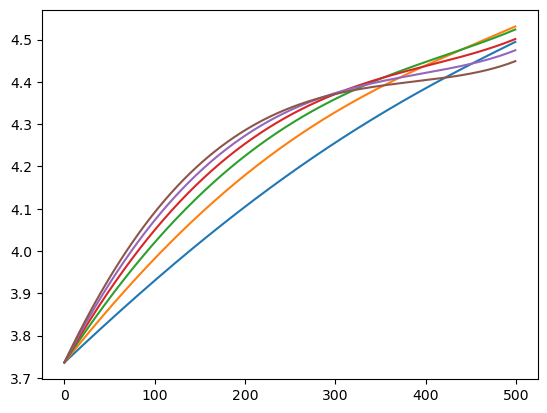

In [97]:
""" 
FIND THE TRANSITION DYNAMICS
"""
T = 75       #The time under consideration
N = 500      #Fineness of the grid
dt = T/N

K_t = np.linspace(K_0, K_st, N)
Knew = copy.deepcopy(K_t)

v = np.zeros((I,J,N))  #v(a,z,t)

maxiteration = 1000
convergence_criterion = 0.5
TFP = 1.1
v[:,:,-1] = v_st
relax = 0.95

A_t = [None]*N
gg_t = [None]*(N+1)
for it in range(maxiteration): ## K(t) -> K*(t)
    print("Iteration: ", it)
    r_t = alpha     * TFP *  K_t**(alpha-1) -delta
    w_t = (1-alpha) * TFP * K_t**(alpha)
    V = copy.deepcopy(v_st)
    # HAMILTON-JACOBI-BELLMAN EQUATION
    for n in range(N-1, -1, -1):   ### from v(:,:,t+1) -> v(:,:,t)
        v[:,:,n] = copy.deepcopy(V)
        Vaf[0:I-1,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w_t[n]*z + r_t[n]*amax)**(-ga)
        Vaf[I-1,:] = re.reshape((J,))
        Vab[1:I,:] = (V[1:I,:]-V[0:I-1,:])/da
        re = (w_t[n]*z + r_t[n]*amin)**(-ga) 
        Vab[0,:] = re.reshape((J,))
        I_concave = Vab > Vaf

        cf = Vaf**(-1/ga)
        sf = w_t[n]*zz + r_t[n]*aa - cf
        cb = Vab**(-1/ga)
        sb = w_t[n]*zz + r_t[n]*aa - cb
        c0 = w_t[n]*zz + r_t[n]*aa
        Va0 = c0**(-ga)
        If = np.where(sf>0, 1, 0)
        Ib = np.where(sb<0, 1, 0)
        I0 = (1-If-Ib)
        Va_Upwind = Vaf*If + Vab*Ib + Va0*I0
        c = Va_Upwind**(-1/ga)
        u = c**(1-ga)/(1-ga)

        # CONSTRUCT MATRIX A
        X = -np.minimum(sb,0)/da   
        Y = -np.maximum(sf,0)/da + np.minimum(sb,0)/da
        Z = np.maximum(sf,0)/da
        Z = Z.reshape(-1,order='F')
        A_up = scipy.sparse.spdiags(np.concatenate([np.array([0]),Z]),1,I*J,I*J)
        Y = Y.reshape(-1,order='F')
        A_diag = scipy.sparse.spdiags(Y, 0, I*J, I*J)
        X = X.reshape(-1,order='F')
        X = np.roll(X, -1)
        A_down = scipy.sparse.spdiags(X, -1, I*J, I*J)
        AA = A_down + A_diag + A_up
        A = AA + Bswitch
        A_t[n] = A
        B = (1/dt + rho)*scipy.sparse.eye(I*J) - A

        u_stack = u.reshape(-1,order='F')
        V_stack = V.reshape(-1,order='F')
        b = u_stack + V_stack/dt

        V_stack = scipy.sparse.linalg.spsolve(B, b)

        V = V_stack.reshape((I,J), order='F')
    gg_t[0] = gg
    for n in range(N):
        AT = A_t[n].T
        gg_t[n+1] = scipy.sparse.linalg.spsolve((scipy.sparse.eye(I*J) - AT*dt), gg_t[n])
        g = gg_t[n].reshape((I,J), order='F')             ## 这里为什么不是n+1?????
        Knew[n] = np.sum(g.T@a*da*dz)
    print('Maximum change in capital is (max(abs(K_t-Knew))):', np.max(np.abs(K_t-Knew)))
    if np.max(np.abs(K_t-Knew)) < convergence_criterion:
        print('done!')
        break
    K_t = relax*K_t+(1-relax)*Knew
    plt.plot(K_t)
    

In [9]:
K_t

array([3.73645226, 3.7376344 , 3.73881655, 3.7399987 , 3.74118084,
       3.74236299, 3.74354514, 3.74472728, 3.74590943, 3.74709158,
       3.74827372, 3.74945587, 3.75063802, 3.75182016, 3.75300231,
       3.75418446, 3.7553666 , 3.75654875, 3.7577309 , 3.75891304,
       3.76009519, 3.76127734, 3.76245948, 3.76364163, 3.76482378,
       3.76600592, 3.76718807, 3.76837022, 3.76955236, 3.77073451,
       3.77191666, 3.7730988 , 3.77428095, 3.7754631 , 3.77664524,
       3.77782739, 3.77900954, 3.78019168, 3.78137383, 3.78255598,
       3.78373812, 3.78492027, 3.78610242, 3.78728456, 3.78846671,
       3.78964886, 3.790831  , 3.79201315, 3.7931953 , 3.79437744,
       3.79555959, 3.79674174, 3.79792388, 3.79910603, 3.80028818,
       3.80147032, 3.80265247, 3.80383462, 3.80501676, 3.80619891,
       3.80738106, 3.8085632 , 3.80974535, 3.8109275 , 3.81210964,
       3.81329179, 3.81447394, 3.81565608, 3.81683823, 3.81802038,
       3.81920252, 3.82038467, 3.82156682, 3.82274896, 3.82393